In [34]:
import numpy as np
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import s1_rtc_bs_utils
import py3dep
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import math
import shapely
import matplotlib.pyplot as plt
import os
import xarray as xr
from datetime import datetime
import ulmo
from datetime import datetime
import sys

In [ ]:
#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
#sys.modules.pop('s1_rtc_bs_utils')
#import s1_rtc_bs_utils

In [2]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 
#
xr.set_options(keep_attrs=True)
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
client

<Client: 'inproc://172.25.45.79/603084/1' processes=1 threads=32, memory=125.71 GiB>

In [3]:
rainier_bbox_gdf = gpd.read_file('shapefiles/mt_rainier.geojson')

# Test get_s1_rtc_stac()

In [4]:
rainier_sar_ds=s1_rtc_bs_utils.get_s1_rtc_stac(rainier_bbox_gdf,start_time='2015-01-01',end_time=datetime.today().strftime('%Y-%m-%d'),orbit_direction='all',polarization='gamma0_vv',collection='mycollection.json')

In [5]:
%%time
# compute frames, drop missing data
rainier_sar_ds = rainier_sar_ds.compute()
rainier_sar_ds = rainier_sar_ds.dropna('time',how='all')

CPU times: user 17.7 s, sys: 2.23 s, total: 20 s
Wall time: 14.3 s


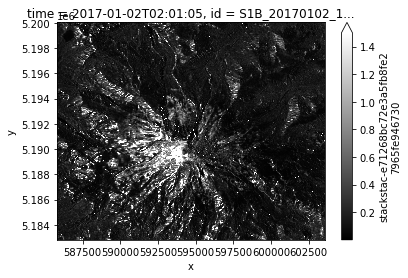

In [6]:
f,ax=plt.subplots()
rainier_sar_ds.isel(time=0).plot(ax=ax,vmax=1.5,cmap='gray')

# Test get_py3dep_dem(), get_py3dep_aspect(), get_py3dep_slope(), get_dah()

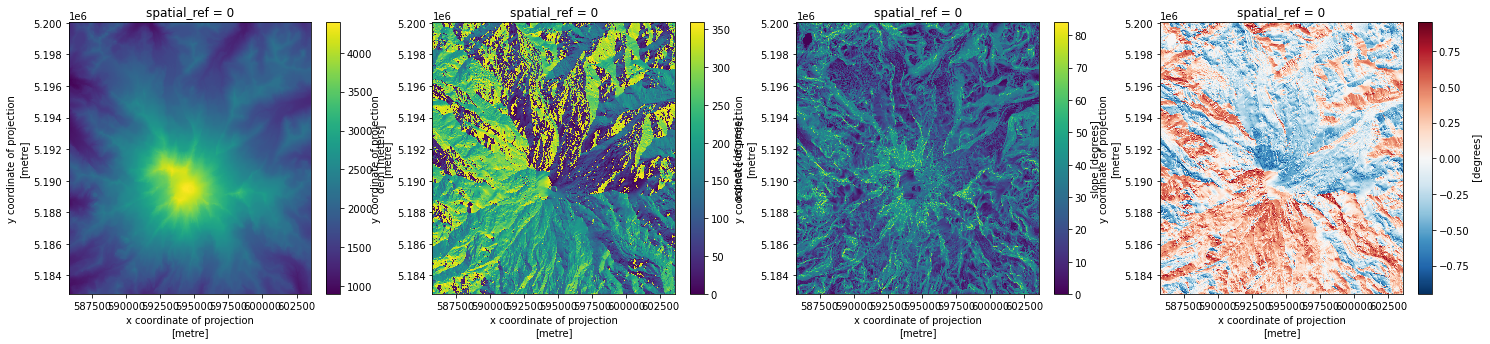

In [7]:
f,ax=plt.subplots(1,4,figsize=(25,5))
s1_rtc_bs_utils.get_py3dep_dem(rainier_sar_ds).plot(ax=ax[0])
s1_rtc_bs_utils.get_py3dep_aspect(rainier_sar_ds).plot(ax=ax[1])
s1_rtc_bs_utils.get_py3dep_slope(rainier_sar_ds).plot(ax=ax[2])
s1_rtc_bs_utils.get_dah(rainier_sar_ds).plot(ax=ax[3])

# Test get_median_ndvi()

In [8]:
dem = s1_rtc_bs_utils.get_py3dep_dem(rainier_sar_ds)
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(rainier_sar_ds)

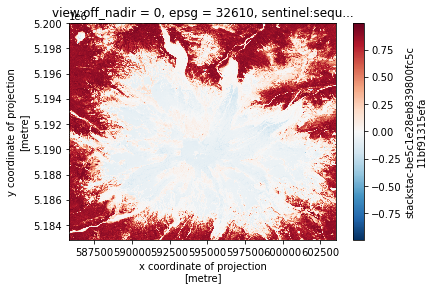

In [9]:
f,ax=plt.subplots()
summer_ndvi_ds.plot(ax=ax)

# Test plot_backscatter_ts_and_ndvi()

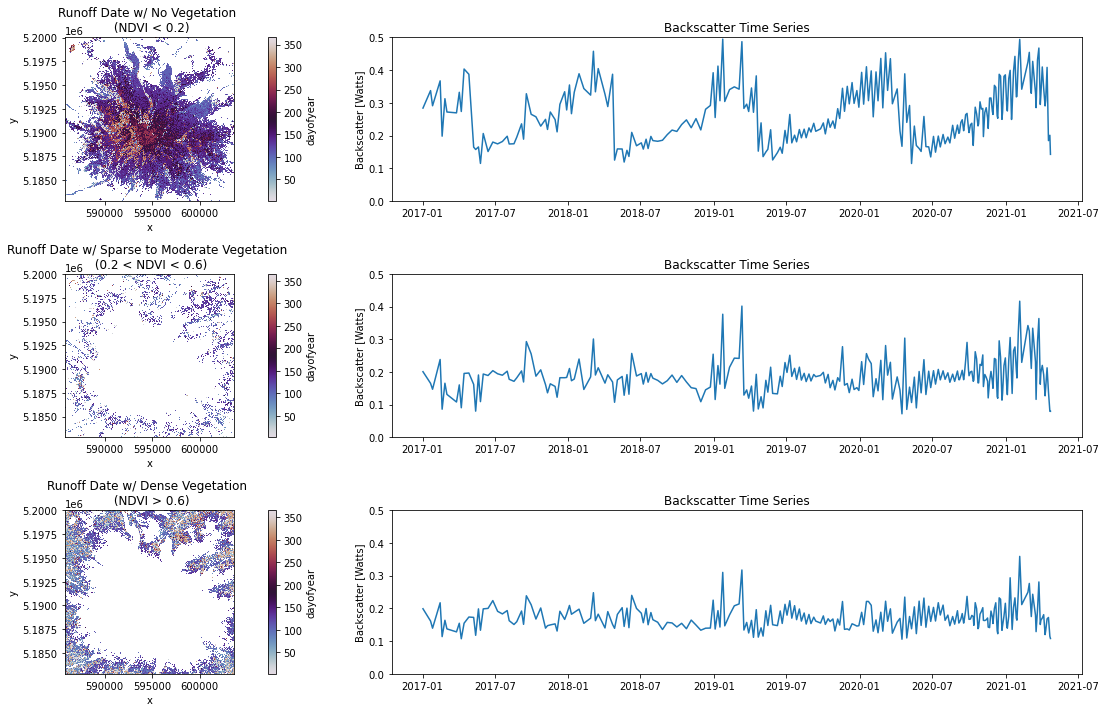

In [10]:
s1_rtc_bs_utils.plot_backscatter_ts_and_ndvi(rainier_sar_ds,summer_ndvi_ds)

# Test get_runoff_onset(), get_ripening_onset()

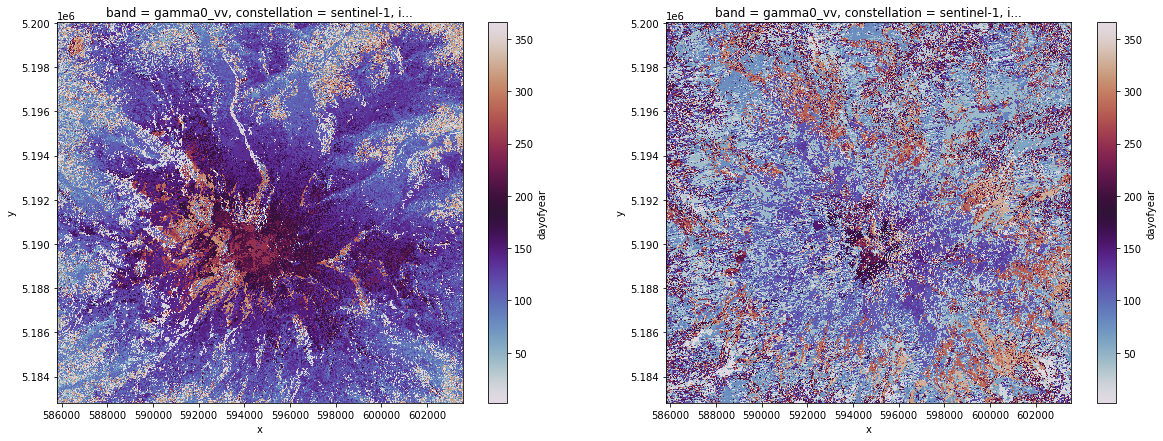

In [11]:
f,ax=plt.subplots(1,2,figsize=(20,7))
s1_rtc_bs_utils.get_runoff_onset(rainier_sar_ds).dt.dayofyear.plot(ax=ax[0],cmap='twilight')
s1_rtc_bs_utils.get_ripening_onset(rainier_sar_ds).dt.dayofyear.plot(ax=ax[1],cmap='twilight')

# Test get_stats()

In [12]:
stats_full_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds)
stats_ndvi_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.where(summer_ndvi_ds<0.2,drop=True))

rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson').to_crs(rainier_sar_ds.crs)
stats_glacier_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False))

In [13]:
stats_full_df.corr()

elevation    aspect  aspect_rescale       dah  \
elevation             1.000000 -0.072703       -0.014787 -0.020199   
aspect               -0.072703  1.000000       -0.017902  0.258516   
aspect_rescale       -0.014787 -0.017902        1.000000 -0.852216   
dah                  -0.020199  0.258516       -0.852216  1.000000   
runoff_dates          0.229783  0.030062        0.064667 -0.052331   
ripening_dates        0.009604 -0.141580        0.042726 -0.102781   
runoff_prediction     0.979127 -0.123442        0.158831 -0.222987   
ripening_prediction   0.093189 -0.262756        0.847601 -0.997328   

                     runoff_dates  ripening_dates  runoff_prediction  \
elevation                0.229783        0.009604           0.979127   
aspect                   0.030062       -0.141580          -0.123442   
aspect_rescale           0.064667        0.042726           0.158831   
dah                     -0.052331       -0.102781          -0.222987   
runoff_dates             1.000000       -0.007997           0.234682   
ripening_dates          -0.007997        1.000000           0.030258   
runoff_prediction        0.234682        0.030258           1.000000   
ripening_prediction      0.068905        0.103057           0.293610   

                     ripening_prediction  
elevation                       0.093189  
aspect                         -0.262756  
aspect_rescale                  0.847601  
dah                            -0.997328  
runoff_dates                    0.068905  
ripening_dates                  0.103057  
runoff_prediction               0.293610  
ripening_prediction             1.000000

In [14]:
stats_ndvi_mask_df.corr()

elevation    aspect  aspect_rescale       dah  \
elevation             1.000000 -0.011124       -0.075605  0.042731   
aspect               -0.011124  1.000000       -0.074700  0.308209   
aspect_rescale       -0.075605 -0.074700        1.000000 -0.850041   
dah                   0.042731  0.308209       -0.850041  1.000000   
runoff_dates          0.404050  0.037392        0.042952 -0.029390   
ripening_dates       -0.057073 -0.113482        0.046867 -0.097333   
runoff_prediction     0.993387 -0.046524        0.022207 -0.072258   
ripening_prediction  -0.515054 -0.259103        0.765454 -0.878383   

                     runoff_dates  ripening_dates  runoff_prediction  \
elevation                0.404050       -0.057073           0.993387   
aspect                   0.037392       -0.113482          -0.046524   
aspect_rescale           0.042952        0.046867           0.022207   
dah                     -0.029390       -0.097333          -0.072258   
runoff_dates             1.000000       -0.047227           0.406740   
ripening_dates          -0.047227        1.000000          -0.045790   
runoff_prediction        0.406740       -0.045790           1.000000   
ripening_prediction     -0.168080        0.110809          -0.413237   

                     ripening_prediction  
elevation                      -0.515054  
aspect                         -0.259103  
aspect_rescale                  0.765454  
dah                            -0.878383  
runoff_dates                   -0.168080  
ripening_dates                  0.110809  
runoff_prediction              -0.413237  
ripening_prediction             1.000000

In [15]:
stats_glacier_mask_df.corr()

elevation    aspect  aspect_rescale       dah  \
elevation             1.000000 -0.045860       -0.119764  0.041737   
aspect               -0.045860  1.000000       -0.111255  0.355929   
aspect_rescale       -0.119764 -0.111255        1.000000 -0.849050   
dah                   0.041737  0.355929       -0.849050  1.000000   
runoff_dates          0.463519  0.032131       -0.000651 -0.002397   
ripening_dates       -0.021461 -0.063354        0.046685 -0.071036   
runoff_prediction     0.998900 -0.062606       -0.080013 -0.005166   
ripening_prediction  -0.292344 -0.329102        0.842894 -0.967682   

                     runoff_dates  ripening_dates  runoff_prediction  \
elevation                0.463519       -0.021461           0.998900   
aspect                   0.032131       -0.063354          -0.062606   
aspect_rescale          -0.000651        0.046685          -0.080013   
dah                     -0.002397       -0.071036          -0.005166   
runoff_dates             1.000000       -0.042296           0.464029   
ripening_dates          -0.042296        1.000000          -0.018145   
runoff_prediction        0.464029       -0.018145           1.000000   
ripening_prediction     -0.114695        0.073409          -0.247173   

                     ripening_prediction  
elevation                      -0.292344  
aspect                         -0.329102  
aspect_rescale                  0.842894  
dah                            -0.967682  
runoff_dates                   -0.114695  
ripening_dates                  0.073409  
runoff_prediction              -0.247173  
ripening_prediction             1.000000

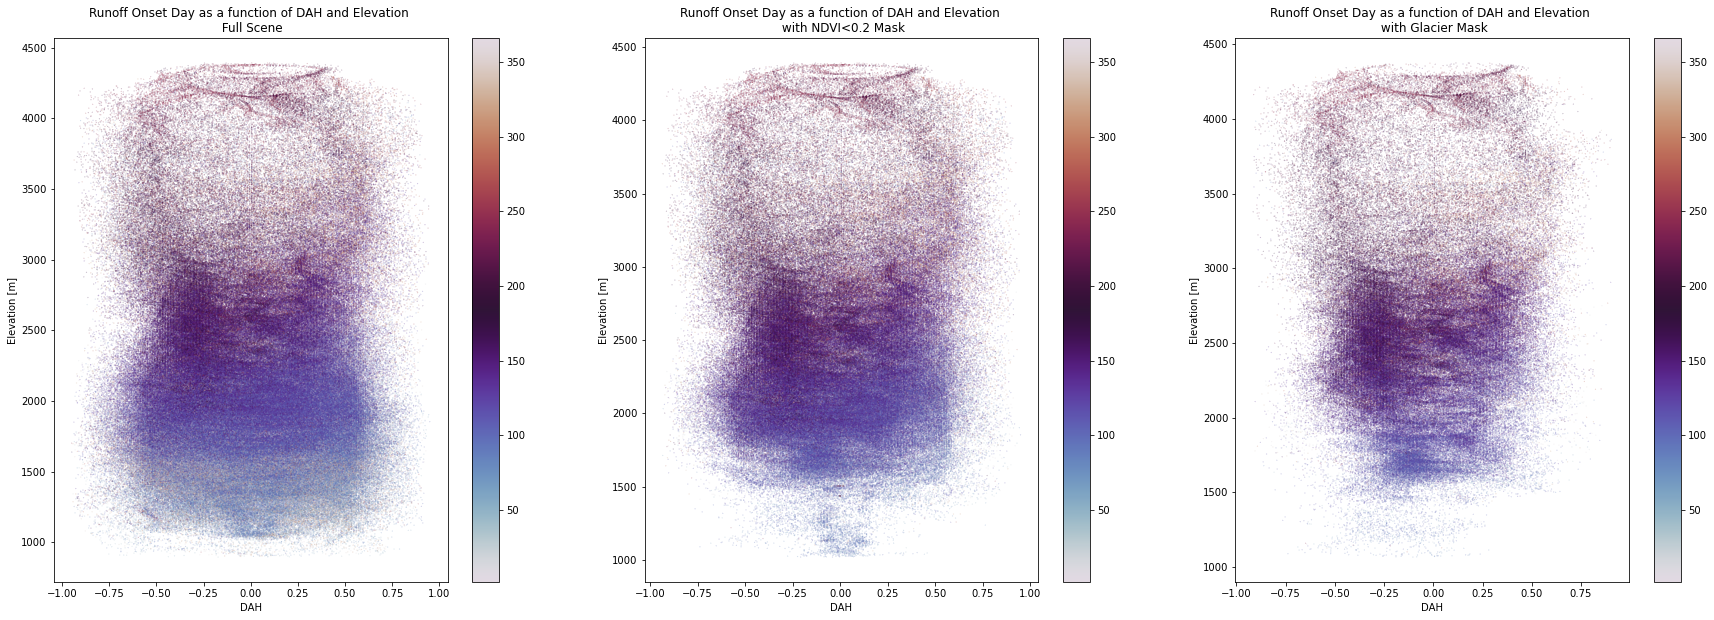

In [16]:
f,ax=plt.subplots(1,3,figsize=(30,10))
color1=ax[0].scatter(stats_full_df['dah'],stats_full_df['elevation'],c=stats_full_df['runoff_dates'],s=0.01,cmap='twilight')
color2=ax[1].scatter(stats_ndvi_mask_df['dah'],stats_ndvi_mask_df['elevation'],c=stats_ndvi_mask_df['runoff_dates'],s=0.01,cmap='twilight')
color3=ax[2].scatter(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],c=stats_glacier_mask_df['runoff_dates'],s=0.01,cmap='twilight')

ax[0].set_title('Runoff Onset Day as a function of DAH and Elevation \n Full Scene')
ax[0].set_xlabel('DAH')
ax[0].set_ylabel('Elevation [m]')

ax[1].set_title('Runoff Onset Day as a function of DAH and Elevation \n with NDVI<0.2 Mask')
ax[1].set_xlabel('DAH')
ax[1].set_ylabel('Elevation [m]')

ax[2].set_title('Runoff Onset Day as a function of DAH and Elevation \n with Glacier Mask')
ax[2].set_xlabel('DAH')
ax[2].set_ylabel('Elevation [m]')

plt.colorbar(color1,ax=ax[0])
plt.colorbar(color2,ax=ax[1])
plt.colorbar(color3,ax=ax[2])

Text(0.5, 1.0, 'MLS Predicted DOY Ripening Date')

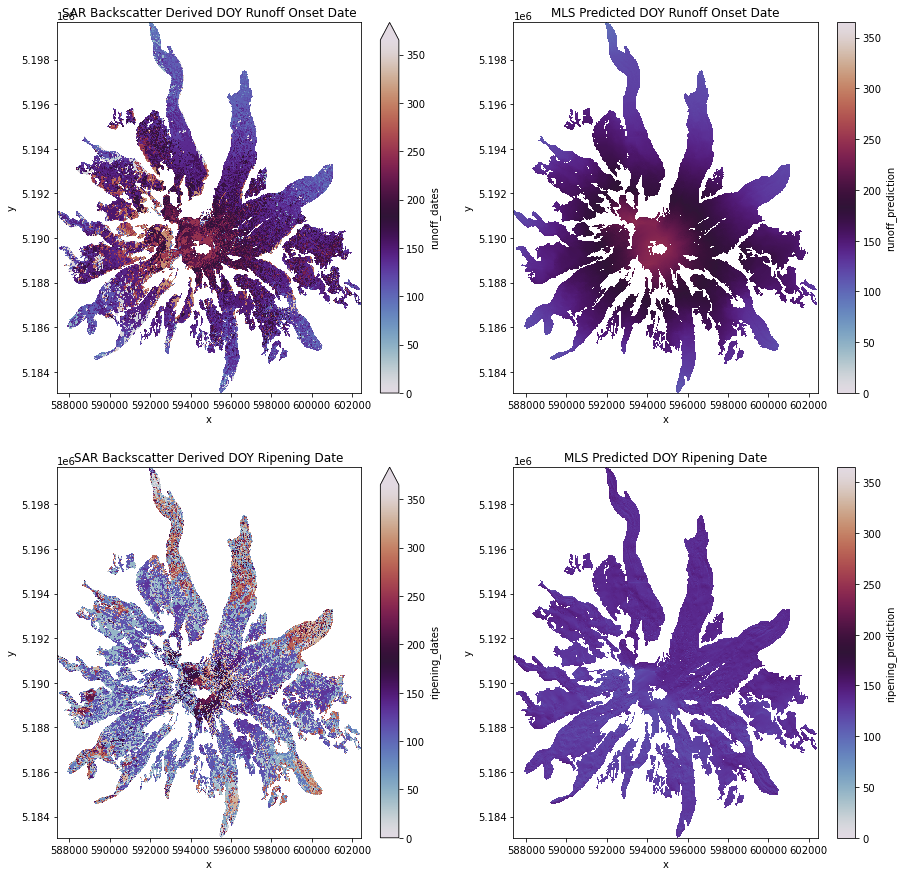

In [24]:
f,ax=plt.subplots(2,2,figsize=(15,15))
stats_glacier_mask_ds = stats_glacier_mask_df.to_xarray() 
stats_glacier_mask_ds['runoff_prediction'].plot(cmap='twilight',ax=ax[0,1],vmin=0,vmax=365)
stats_glacier_mask_ds['runoff_dates'].plot(cmap='twilight',ax=ax[0,0],vmin=0,vmax=365)
ax[0,0].set_title('SAR Backscatter Derived DOY Runoff Onset Date')
ax[0,1].set_title('MLS Predicted DOY Runoff Onset Date')
stats_glacier_mask_ds['ripening_prediction'].plot(cmap='twilight',ax=ax[1,1],vmin=0,vmax=365)
stats_glacier_mask_ds['ripening_dates'].plot(cmap='twilight',ax=ax[1,0],vmin=0,vmax=365)
ax[1,0].set_title('SAR Backscatter Derived DOY Ripening Date')
ax[1,1].set_title('MLS Predicted DOY Ripening Date')

# Test plot_timeseries_by_elevation_bin(), plot_hyposometry()

In [18]:
resample_freq_s1='2W'
rainier_sar_2w_ds = rainier_sar_ds.where(summer_ndvi_ds.values<0.2).resample(time='2W').mean(dim='time')

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: backscatter means for a given 100m elevation bin \n top 2 rows are all data, bottom 2 rows are 2 week resampled means')

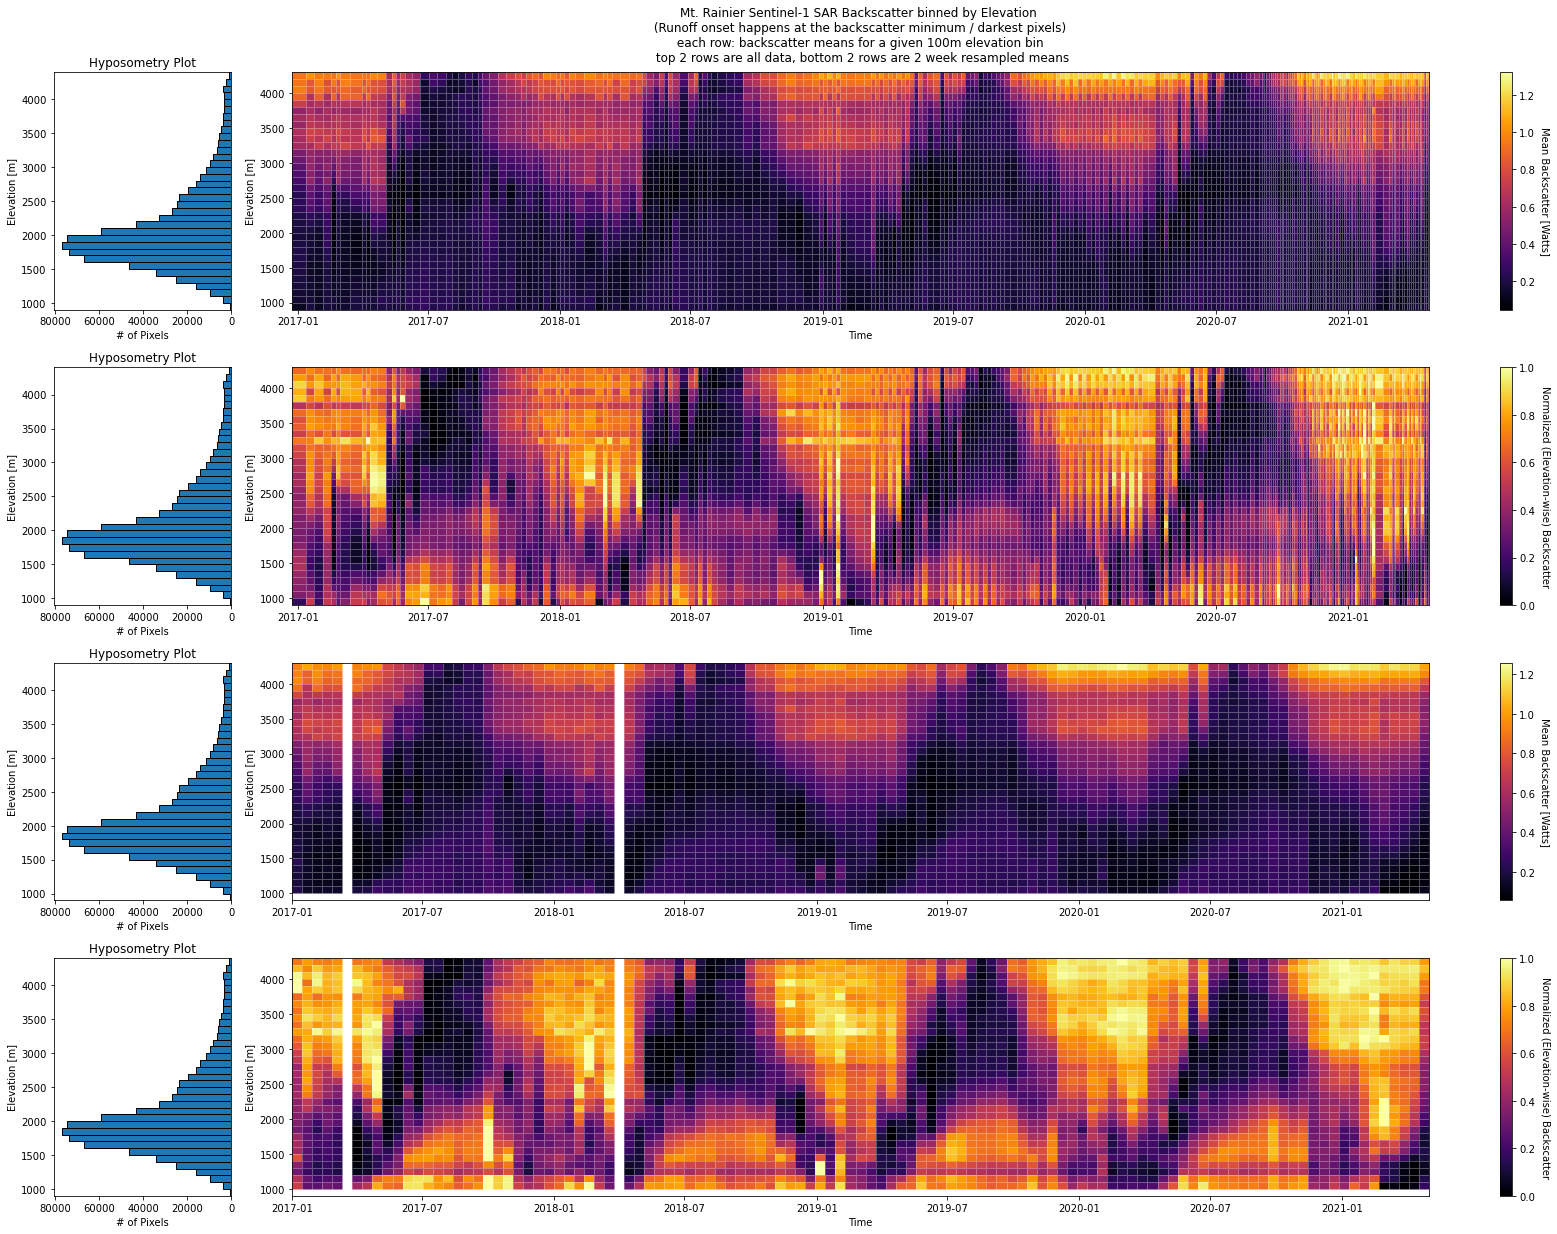

In [19]:
f,ax=plt.subplots(4,2,figsize=(24,18),gridspec_kw={'width_ratios': [1, 8]})
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_ds,dem,bin_size=100,ax=ax[0,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_ds,dem,bin_size=100,ax=ax[1,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_ds,dem,bin_size=100,ax=ax[0,0])
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_ds,dem,bin_size=100,ax=ax[1,0])
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[2,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[3,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[2,0])
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[3,0])
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[3,0].invert_xaxis()
#plt.tight_layout()
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: backscatter means for a given 100m elevation bin \n top 2 rows are all data, bottom 2 rows are 2 week resampled means")

# Test plot_timeseries_by_dah_bin(), plot_dah_bins()

In [20]:
dah = s1_rtc_bs_utils.get_dah(rainier_sar_ds)

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by DAH \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each column: backscatter for a given 0.25 DAH bin \n (DAH = 1 has greatest insolation, DAH = -1 has the least insolation)')

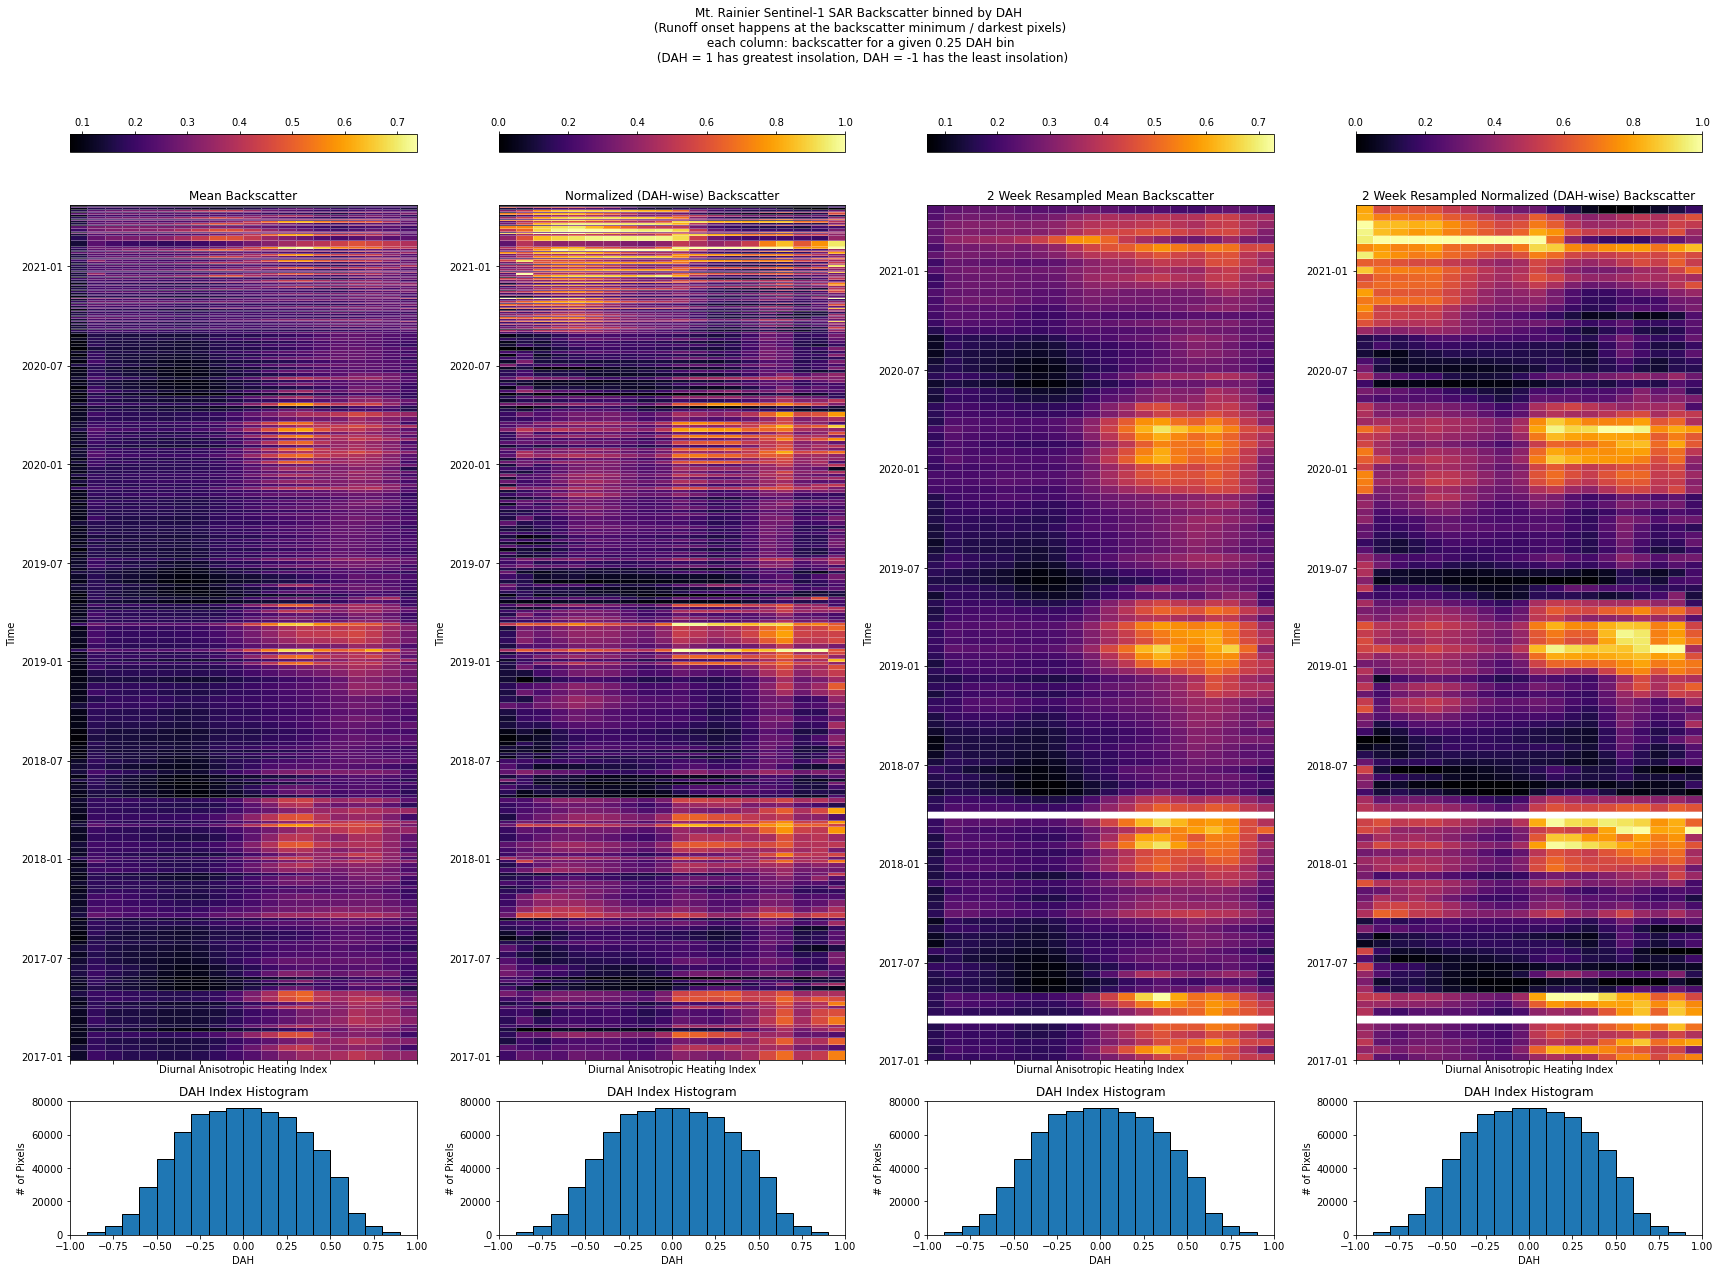

In [21]:
bin_size = 0.1
f,ax=plt.subplots(2,4,figsize=(24,18),sharex=True,gridspec_kw={'height_ratios': [8, 1]})
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[0,0],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[0,1],normalize_bins=True)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[0,2],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[0,3],normalize_bins=True)

s1_rtc_bs_utils.plot_dah_bins(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[1,0])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[1,1])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[1,2])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[1,3])

ax[0,0].set_title('Mean Backscatter')
ax[0,1].set_title('Normalized (DAH-wise) Backscatter')
ax[0,2].set_title('2 Week Resampled Mean Backscatter')
ax[0,3].set_title('2 Week Resampled Normalized (DAH-wise) Backscatter')
#plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.tight_layout()
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by DAH \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each column: backscatter for a given 0.25 DAH bin \n (DAH = 1 has greatest insolation, DAH = -1 has the least insolation)")

# Test find_closest_snotel()

In [51]:
s1_rtc_bs_utils.find_closest_snotel(rainier_sar_ds)

code            name  elevation_m  \
SNOTEL:679_WA_SNTL    679_WA_SNTL        Paradise  1563.624023   
SNOTEL:941_WA_SNTL    941_WA_SNTL          Mowich   963.168030   
SNOTEL:1085_WA_SNTL  1085_WA_SNTL     Cayuse Pass  1597.151978   
SNOTEL:942_WA_SNTL    942_WA_SNTL  Burnt Mountain  1271.015991   
SNOTEL:642_WA_SNTL    642_WA_SNTL      Morse Lake  1648.968018   
...                           ...             ...          ...   
SNOTEL:1177_AK_SNTL  1177_AK_SNTL     Prudhoe Bay     9.144000   
SNOTEL:986_AK_SNTL    986_AK_SNTL    Pargon Creek    30.480000   
SNOTEL:973_AK_SNTL    973_AK_SNTL     Rocky Point    76.199997   
SNOTEL:1036_AK_SNTL  1036_AK_SNTL   Johnsons Camp     7.620000   
SNOTEL:1175_AK_SNTL  1175_AK_SNTL   Kelly Station    94.487999   

                                             geometry  distance_km  
SNOTEL:679_WA_SNTL     POINT (595595.572 5181772.683)     1.037317  
SNOTEL:941_WA_SNTL     POINT (579756.913 5197732.382)     6.033087  
SNOTEL:1085_WA_SNTL    POINT (611700.715 5191709.650)     8.130715  
SNOTEL:942_WA_SNTL     POINT (580495.481 5210642.884)    11.860238  
SNOTEL:642_WA_SNTL     POINT (615555.470 5195819.019)    11.985470  
...                                               ...          ...  
SNOTEL:1177_AK_SNTL   POINT (-438458.080 7996787.513)  2978.411777  
SNOTEL:986_AK_SNTL   POINT (-1285933.578 7807093.295)  3209.381277  
SNOTEL:973_AK_SNTL   POINT (-1330776.287 7774460.473)  3209.504415  
SNOTEL:1036_AK_SNTL  POINT (-1362951.239 7803978.992)  3252.405689  
SNOTEL:1175_AK_SNTL  POINT (-1050623.475 8053939.026)  3289.778988  

[930 rows x 5 columns]

# Test plot_closest_snotel()

<AxesSubplot:title={'center':'SNOTEL Sites Around Study Site'}, xlabel='x', ylabel='y'>

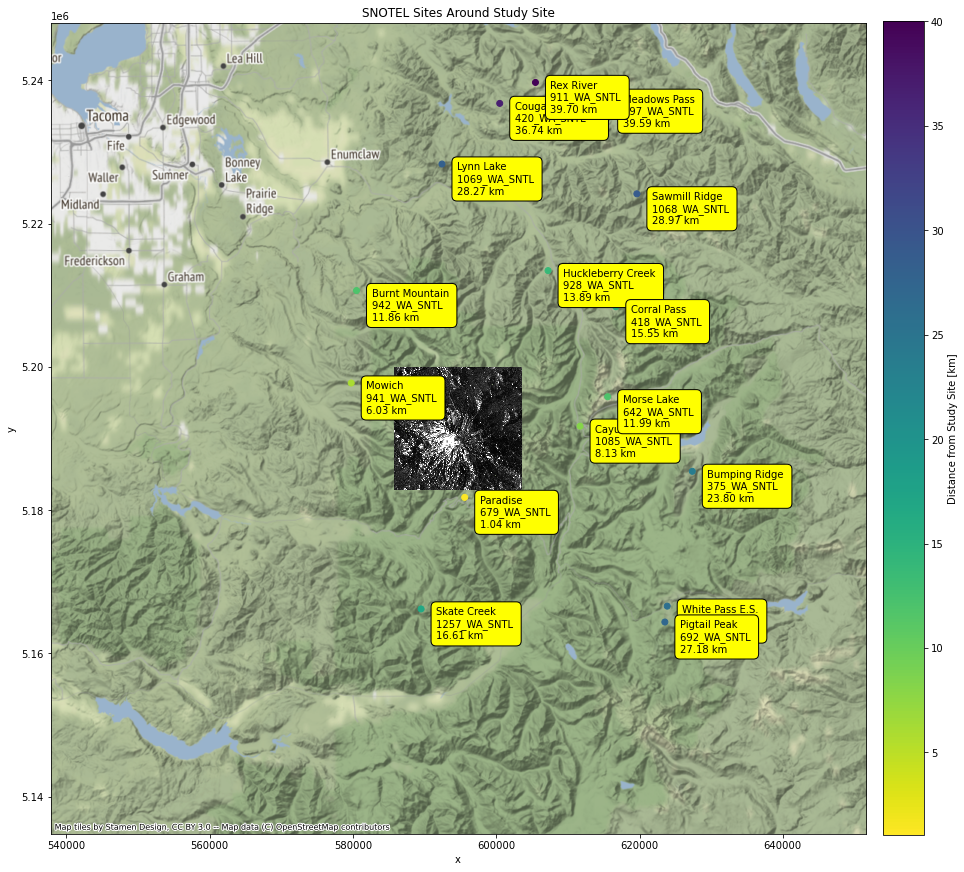

In [87]:
f, ax = plt.subplots(figsize=(15,15))
s1_rtc_bs_utils.plot_closest_snotel(rainier_sar_ds,distance_cutoff=40,ax=ax)

# Test get_snotel()

In [89]:
sitecode = 'SNOTEL:679_WA_SNTL'
#variablecode = 'SNOTEL:TAVG_D'
#variablecode = 'SNOTEL:PRCPSA_D'
#variablecode = 'SNOTEL:WTEQ_D'
values_df = s1_rtc_bs_utils.get_snotel(sitecode, variablecode,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
values_df['value'] = 2.54*values_df['value'] #inches to cm
values_df

value qualifiers censor_code  \
datetime                                                    
1980-10-01 00:00:00+00:00    0.000          E          nc   
1980-10-02 00:00:00+00:00    0.000          E          nc   
1980-10-03 00:00:00+00:00    0.000          E          nc   
1980-10-04 00:00:00+00:00    0.000          E          nc   
1980-10-05 00:00:00+00:00    0.000          E          nc   
...                            ...        ...         ...   
2022-04-21 00:00:00+00:00  189.230          V          nc   
2022-04-22 00:00:00+00:00  189.738          V          nc   
2022-04-23 00:00:00+00:00  190.246          V          nc   
2022-04-24 00:00:00+00:00  186.944          V          nc   
2022-04-25 00:00:00+00:00  185.420          V          nc   

                                 date_time_utc method_id method_code  \
datetime                                                               
1980-10-01 00:00:00+00:00  1980-10-01T00:00:00         0           0   
1980-10-02 00:00:00+00:00  1980-10-02T00:00:00         0           0   
1980-10-03 00:00:00+00:00  1980-10-03T00:00:00         0           0   
1980-10-04 00:00:00+00:00  1980-10-04T00:00:00         0           0   
1980-10-05 00:00:00+00:00  1980-10-05T00:00:00         0           0   
...                                        ...       ...         ...   
2022-04-21 00:00:00+00:00  2022-04-21T00:00:00         0           0   
2022-04-22 00:00:00+00:00  2022-04-22T00:00:00         0           0   
2022-04-23 00:00:00+00:00  2022-04-23T00:00:00         0           0   
2022-04-24 00:00:00+00:00  2022-04-24T00:00:00         0           0   
2022-04-25 00:00:00+00:00  2022-04-25T00:00:00         0           0   

                          source_code quality_control_level_code  
datetime                                                          
1980-10-01 00:00:00+00:00           1                          1  
1980-10-02 00:00:00+00:00           1                          1  
1980-10-03 00:00:00+00:00           1                          1  
1980-10-04 00:00:00+00:00           1                          1  
1980-10-05 00:00:00+00:00           1                          1  
...                               ...                        ...  
2022-04-21 00:00:00+00:00           1                          1  
2022-04-22 00:00:00+00:00           1                          1  
2022-04-23 00:00:00+00:00           1                          1  
2022-04-24 00:00:00+00:00           1                          1  
2022-04-25 00:00:00+00:00           1                          1  

[15182 rows x 8 columns]

# Test get_closest_snotel_data()

In [90]:
snotel_data = s1_rtc_bs_utils.get_closest_snotel_data(rainier_sar_ds,variable_code='SNOTEL:SNWD_D',distance_cutoff=30,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))

Text(0.5, 1.0, 'Snow Depth for SNOTEL Stations Close in Proximety to Dataset')

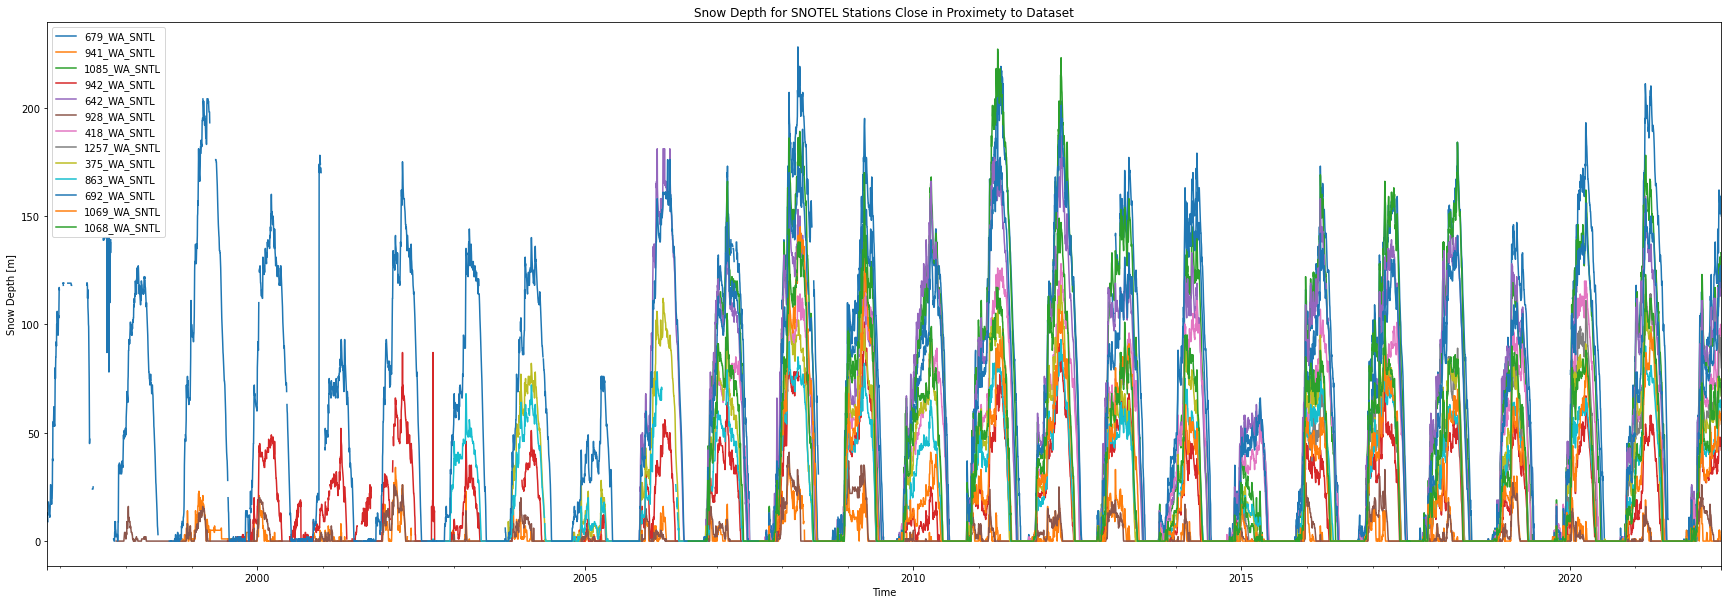

In [91]:
f, ax = plt.subplots(figsize=(30,10))
snotel_data.plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Snow Depth [m]')
ax.set_title('Snow Depth for SNOTEL Stations Close in Proximety to Dataset')

In [ ]:
# TODO .get_s2optical() .aggregate_by_time() .plot_gif() .plot_runoff() .plot_ripening() .plot_bs_snotel_ndsi()